<a href="https://colab.research.google.com/github/Oyekanmi/Machine-Learning-New/blob/master/Income%20Predictions%20with%20ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Census Income**

Predict if an individual makes greater or less than $50000 per year


**Attribute Details**:

**Name**	Type	Description

**age**	integer	age of individual

**workclass**	string	Values: 

**fnlwgt**	float	Final sampling weight. 

**education**	string	Values: 

**education_num**	integer	

**marital_status**	string	Values:

**occupation**	string	Values: 

**relationship**	string	Values: 

**race**	string	Values: 

**sex**	string	Values: Female, Male

**capital_gain**	float	

**capital_loss**	float	

**hours_per_week**	float	working hours per week

**native_country**	string	Values: 

**income_level**	string	Predictor class if individual earns greater or less than $50000 per year. Values: <=50K, >50K


In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#import machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#Hyperparameter Tuning

#import Deep Learning Libraries
import tensorflow as tf

#import evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
census_income = pd.read_csv('census_income_dataset.csv')  #load dataframe

census_income.head() #view the first five rows

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [3]:
# replace the income level with a value of 1 or 0 : 1 for income > 50k and 0 for income <= 50k

census_income['income_level'] = census_income.loc[:,'income_level'].apply (lambda x: 0 if x == '<=50K' else 1)

census_income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,0
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,0
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,0
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,0
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,0


In [4]:
census_income.shape   #check the size of the dataset

(48842, 15)

In [5]:
census_income.loc[:,'income_level'].value_counts()     #check for the size of each class present 

0    37155
1    11687
Name: income_level, dtype: int64

The result shows that we have uneven classes present . 37155 people with income <=50K and 11687 people with income > 50k.

**Data Preparation and EDA**

In [6]:
country_counts = census_income.loc[:,'native_country'].value_counts(normalize=True)    #count the number of unique values in the country column

country_by_percent = country_counts * 100          # conver to percentage

print(country_by_percent.head(10))    #view the first five rows


United-States    89.742435
Mexico            1.947095
?                 1.754637
Philippines       0.603988
Germany           0.421768
Puerto-Rico       0.376725
Canada            0.372630
El-Salvador       0.317350
India             0.309160
Cuba              0.282544
Name: native_country, dtype: float64


Result above shows that about 90% of the dataset is from the United States . 

In [7]:
census_income.isna().sum()   #check for missing value

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income_level      0
dtype: int64

In [8]:
#exclude rows whose native_country is unknown or 'Holand-Netherlands'
census_income = census_income[(census_income['native_country'] != '?') ]    # exclude rows whose native is ?

print(f" The new dataframe has {census_income.shape[0]} rows and {census_income.shape[1]} columns")

 The new dataframe has 47985 rows and 15 columns


Text(0.5, 1.0, 'Distribution of Age')

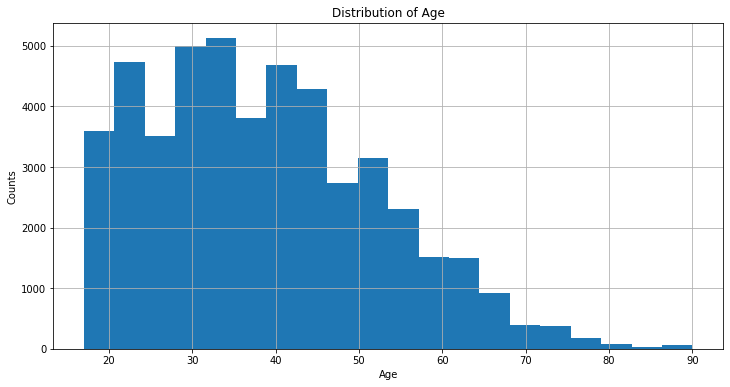

In [9]:
#check the age distribution
census_income['age'].hist(bins=20, figsize= (12,6))
plt.xlabel('Age')
plt.ylabel('Counts')
plt.title('Distribution of Age')

The result shows that the dataset is skewed to the right.The ages of most people falls between 20 and 65 years

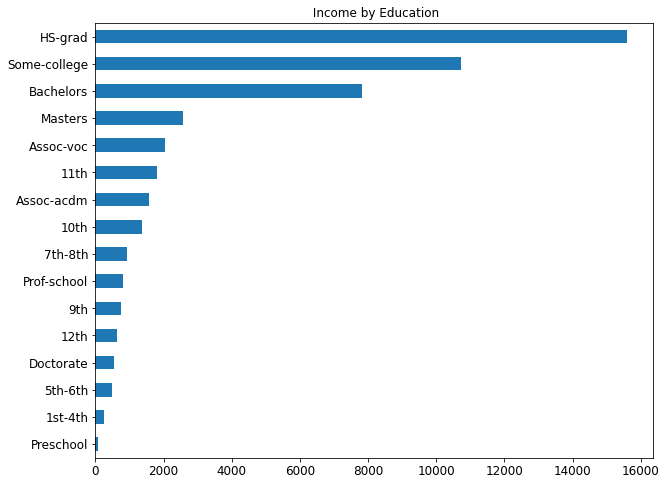

In [10]:
census_income['education'].value_counts().sort_values().plot(kind='barh', figsize = (10,8), title=' Income by Education')   # check for the highest education of the people 
plt.tick_params(axis='both', labelsize=12)

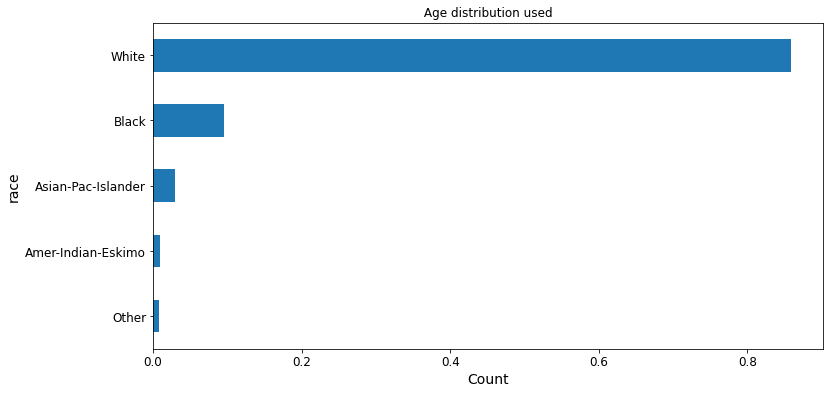

In [11]:
census_income.loc[:,'race'].value_counts(normalize=True).sort_values().plot(kind='barh', figsize = (12,6), title=' Age distribution used ')    # Check the age distribution of the data 

plt.xlabel('Count', fontsize=14)  #set x label
plt.ylabel('race', fontsize = 14)   #set y label
plt.tick_params(axis='both', labelsize=12)  #increase the axis font size

Over 80% of the demographics of the data collected consist of white people

In [12]:
# Since 'relationship' and 'education' columns are redundants , we can drop them

census_income.drop(labels= ['relationship', 'education'], axis= 'columns' , inplace=True )  

In [13]:
print(f" The new dataframe has {census_income.shape[0]} rows and {census_income.shape[1]} columns")

 The new dataframe has 47985 rows and 13 columns


In [14]:
# Count the number of '?' in the dataframe
count= 0

for i in range(47985):
  for j in range(12):
    if census_income.iloc[i,j]== '?':
      count+=1
    else:
      pass

In [15]:
print( f"There are {count} '?' present in the data")

There are 5516 '?' present in the data


In [16]:
#Get the row indices that countains '?
index_with_mark = []         #initiate an empty list
count = 0
for i in range(47985):   #iterate over all rows
  for j in range(12):    #iterate over all columns
    if census_income.iloc[i,j]== '?':      #check for '?'
      index_with_mark.append(i)
      count+=1
    else:
      pass

In [17]:
print(f"There are {len(set(index_with_mark))} unique indices that contains '?' ")  #count the number of unique rows with '?' present in the dataframe

unique_indices = list(set(index_with_mark))  #get the number of unique indices

There are 2763 unique indices that contains '?' 


In [18]:
census_income.drop(census_income.index[unique_indices], inplace=True)      #drop the rows which contains ?

In [19]:
census_income.shape

(45222, 13)

In [20]:
#Verify that no columns contains '?
index_with_mark = []         #initiate an empty list
count = 0
for i in range(len(census_income)-1):   #iterate over all rows
  for j in range(12):    #iterate over all columns
    if census_income.iloc[i,j]== '?':      #check for '?'
      index_with_mark.append(i)
      count+=1
    else:
      pass

len(index_with_mark)

0

In [21]:
pd.crosstab(census_income.sex, census_income.race )   

race,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
sex,,,,,
Female,166,436,2084,126,11883
Male,269,867,2144,227,27020


In [22]:
# View the first five rows of the dataset

census_income.head()

,age,workclass,fnlwgt,education_num,marital_status,occupation,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,39,State-gov,77516.0,13,Never-married,Adm-clerical,White,Male,2174.0,0.0,40.0,United-States,0
1,50,Self-emp-not-inc,83311.0,13,Married-civ-spouse,Exec-managerial,White,Male,0.0,0.0,13.0,United-States,0
2,38,Private,215646.0,9,Divorced,Handlers-cleaners,White,Male,0.0,0.0,40.0,United-States,0
3,53,Private,234721.0,7,Married-civ-spouse,Handlers-cleaners,Black,Male,0.0,0.0,40.0,United-States,0
4,28,Private,338409.0,13,Married-civ-spouse,Prof-specialty,Black,Female,0.0,0.0,40.0,Cuba,0


In [23]:
census_income.workclass.value_counts()  #check the distribution of values for the workclass column

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: workclass, dtype: int64

**Split Dataset into Training , Validation and Test Set**



Define a function that Splits into Training , Validation and Test Sets



In [24]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.7, frac_val=0.15, frac_test=0.15,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)
    return df_train, df_val, df_test

In [25]:
# Split the dataframe into train, val and test set
df_train,df_val,df_test = split_stratified_into_train_val_test(census_income, stratify_colname='income_level',
                                         frac_train=0.7, frac_val=0.15, frac_test=0.15,
                                         random_state=42)

# print the shapes of training , validation and test data
print(f"Shape of training data {df_train.shape}")
print(f"Shape of validation data {df_val.shape}")
print(f"Shape of test data {df_test.shape}")


# Create the training variables 
X_train = df_train.loc[:, :'native_country' ]
y_train = df_train.loc[:, 'income_level' ]

# Create the validation variables 
X_val = df_val.loc[:, :'native_country' ]
y_val = df_val.loc[:, 'income_level' ]

#create the test variables
X_test = df_test.loc[:, :'native_country' ]
y_test = df_test.loc[:, 'income_level' ]

Shape of training data (31655, 13)
Shape of validation data (6783, 13)
Shape of test data (6784, 13)


In [26]:
y_train.value_counts()  #check the class proportion

0    23809
1     7846
Name: income_level, dtype: int64

In [27]:
# create a list of the numerical col and categorical columns
categorical_col = [col for col in X_train.columns if X_train[col].dtypes == 'object']
print(categorical_col)

numerical_col = list (set(X_train.columns) - set(categorical_col))
print('\n')

print(numerical_col)

['workclass', 'marital_status', 'occupation', 'race', 'sex', 'native_country']


['age', 'fnlwgt', 'capital_gain', 'education_num', 'capital_loss', 'hours_per_week']


Preprocessing for Dataset

In [28]:
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')   # convert to dummy variables
feature_scaling = StandardScaler()  #feature scaling
column_tranformer = make_column_transformer((feature_scaling, numerical_col), (ohe, categorical_col) , remainder='passthrough')

#Training Set
X_train1 = column_tranformer.fit_transform(X_train)

#Validation Set
X_val1 = column_tranformer.transform(X_val)

#Testing Set
X_test1 = column_tranformer.transform(X_test)

In [29]:
#X_train1= pd.get_dummies(data=X_train, columns=categorical_col)    #get dummies for each categorical variables

#Scale the numerical columns 
#ct = make_column_transformer((StandardScaler(), numerical_col), remainder= 'passthrough')        # scale the numerical features
#X_train= ct.fit_transform(X_train1)

In [30]:
print (f"The data type of X_train: {type(X_train1)}")
print (f" The data type of y_train: {type(y_train)}" )

The data type of X_train: <class 'numpy.ndarray'>
 The data type of y_train: <class 'pandas.core.series.Series'>


In [35]:
#Define a function for model evaluation
def generate_model_report(y_test, y_pred):
  print(f"Accuracy: {accuracy_score(y_test,y_pred)}")
  print(f"Precision: {precision_score(y_test,y_pred)}")
  print(f"Recall: {recall_score(y_test,y_pred)}")
  print(f"F1 Score: {f1_score(y_test,y_pred)}")
  pass

**Create and Train the ANN**

In [31]:
ann = tf.keras.Sequential() #intialize the ANN

ann.add(tf.keras.layers.Dense(units=10, activation='relu')) # add the input and the first hidden layer

#ann.add(tf.keras.layers.Dense(units=82, activation='relu')) # add second hidden layer

ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  #add the final output later

ann.compile(optimizer='adam' , loss= 'binary_crossentropy', metrics=['accuracy'])      #compile the NN
  
ann.fit(X_train1,y_train, batch_size= 32 , epochs=10)

print('*'*20)

print("\n")

print("Training Score and Accuracy")
score, acc = ann.evaluate(X_train1, y_train, batch_size=32)
print('Train score:', score)
print('Train accuracy:', acc)

# Predicting the Validation set results
y_pred = ann.predict(X_val1)
y_pred = (y_pred > 0.5)

print('*'*20)

print("\n")
print("Validation Score and Accuracy")
score, acc = ann.evaluate(X_val1, y_val, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

print("\n")

print ("Evaluation metrics")

generate_model_report(y_val, y_pred)
  

Epoch 1/10
990/990 [==============================] - 1s 2ms/step - loss: 0.3954 - accuracy: 0.8128
Epoch 2/10
990/990 [==============================] - 1s 1ms/step - loss: 0.3266 - accuracy: 0.8486
Epoch 3/10
990/990 [==============================] - 1s 1ms/step - loss: 0.3225 - accuracy: 0.8508
Epoch 4/10
990/990 [==============================] - 1s 1ms/step - loss: 0.3198 - accuracy: 0.8524
Epoch 5/10
990/990 [==============================] - 1s 1ms/step - loss: 0.3174 - accuracy: 0.8533
Epoch 6/10
990/990 [==============================] - 1s 1ms/step - loss: 0.3156 - accuracy: 0.8545
Epoch 7/10
990/990 [==============================] - 1s 1ms/step - loss: 0.3140 - accuracy: 0.8541
Epoch 8/10
990/990 [==============================] - 1s 1ms/step - loss: 0.3121 - accuracy: 0.8552
Epoch 9/10
990/990 [==============================] - 1s 1ms/step - loss: 0.3113 - accuracy: 0.8554
Epoch 10/10
990/990 [==============================] - 1s 1ms/step - loss: 0.3105 - accuracy: 0.8562

array([[4757,  345],
       [ 670, 1011]])

**Train the ANN for different parameters**

In [38]:
epochs = [50,100,150,200]    #randomly selected parameters
input_units = [40,82,160]

for epoch in epochs:
    for unit in input_units:

        ann = tf.keras.Sequential() #intialize the ANN

        ann.add(tf.keras.layers.Dense(units=unit, activation='relu')) # add the input and the first hidden layer

        ann.add(tf.keras.layers.Dense(units=unit, activation='relu')) # add second hidden layer

        ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  #add the final output later

        ann.compile(optimizer='adam' , loss= 'binary_crossentropy', metrics=['accuracy'])      #compile the NN
          
        ann.fit(X_train1,y_train, batch_size= 32 , epochs=epoch)

        print('*'*20)

        print("\n")

        print(f"Training Score and Accuracy at epoch: {epoch} and unit: {unit}")
        score, acc = ann.evaluate(X_train1, y_train, batch_size=32)
        print('Train score:', score)
        print('Train accuracy:', acc)

        # Predicting the Validation set results
        y_pred = ann.predict(X_val1)
        y_pred = (y_pred > 0.5)

        print('*'*20)

        print("\n")
        print(f"Validation Score and Accuracy at epoch: {epoch} and unit:{unit}")
        score, acc = ann.evaluate(X_val1, y_val, batch_size=32)
        print('Test score:', score)
        print('Test accuracy:', acc)
        


        print("\n")
        print ("Model Evaluation Metrics")
        generate_model_report(y_val, y_pred)

Epoch 1/50
990/990 [==============================] - 2s 2ms/step - loss: 0.3424 - accuracy: 0.8390
Epoch 2/50
990/990 [==============================] - 2s 2ms/step - loss: 0.3167 - accuracy: 0.8529
Epoch 3/50
990/990 [==============================] - 2s 2ms/step - loss: 0.3124 - accuracy: 0.8548
Epoch 4/50
990/990 [==============================] - 2s 2ms/step - loss: 0.3100 - accuracy: 0.8559
Epoch 5/50
990/990 [==============================] - 1s 1ms/step - loss: 0.3083 - accuracy: 0.8580
Epoch 6/50
990/990 [==============================] - 2s 2ms/step - loss: 0.3061 - accuracy: 0.8589
Epoch 7/50
990/990 [==============================] - 2s 2ms/step - loss: 0.3043 - accuracy: 0.8597
Epoch 8/50
990/990 [==============================] - 2s 2ms/step - loss: 0.3026 - accuracy: 0.8593
Epoch 9/50
990/990 [==============================] - 1s 1ms/step - loss: 0.3008 - accuracy: 0.8606
Epoch 10/50
990/990 [==============================] - 2s 2ms/step - loss: 0.2992 - accuracy: 0.8619

**The best perfomance on the validation set occur at  epoch:100 , unit = 40 **

**Finalize the ANN Model on the Test Set**

Use Epoch : 100 and unit:40

In [41]:
ann = tf.keras.Sequential() #intialize the ANN

ann.add(tf.keras.layers.Dense(units=40, activation='relu')) # add the input and the first hidden layer

ann.add(tf.keras.layers.Dense(units=40, activation='relu')) # add second hidden layer
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  #add the final output later
ann.compile(optimizer='adam' , loss= 'binary_crossentropy', metrics=['accuracy'])      #compile the NN
ann.fit(X_train1,y_train, batch_size= 32 , epochs=100)

print('*'*20)

print("\n")

print(f"Training Score and Accuracy at epoch: {epoch} and unit: {unit}")
score, acc = ann.evaluate(X_train1, y_train, batch_size=32)
print('Train score:', score)
print('Train accuracy:', acc)

# Predicting the Validation set results
y_pred = ann.predict(X_test1)
y_pred = (y_pred > 0.5)

print('*'*20)

print("\n")
score, acc = ann.evaluate(X_test1, y_test, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)
        

print("\n")
print ("Model Evaluation Metrics")
generate_model_report(y_test, y_pred)


Epoch 1/100
990/990 [==============================] - 2s 2ms/step - loss: 0.3420 - accuracy: 0.8396
Epoch 2/100
990/990 [==============================] - 2s 2ms/step - loss: 0.3155 - accuracy: 0.8532
Epoch 3/100
990/990 [==============================] - 2s 2ms/step - loss: 0.3119 - accuracy: 0.8567
Epoch 4/100
990/990 [==============================] - 2s 2ms/step - loss: 0.3090 - accuracy: 0.8567
Epoch 5/100
990/990 [==============================] - 1s 1ms/step - loss: 0.3072 - accuracy: 0.8569
Epoch 6/100
990/990 [==============================] - 1s 1ms/step - loss: 0.3053 - accuracy: 0.8602
Epoch 7/100
990/990 [==============================] - 1s 1ms/step - loss: 0.3032 - accuracy: 0.8595
Epoch 8/100
990/990 [==============================] - 1s 1ms/step - loss: 0.3018 - accuracy: 0.8607
Epoch 9/100
990/990 [==============================] - 1s 2ms/step - loss: 0.2998 - accuracy: 0.8610
Epoch 10/100
990/990 [==============================] - 2s 2ms/step - loss: 0.2990 - accura

In [42]:
print("Generate Confusion Matrix")

confusion_matrix(y_test, y_pred)

Generate Confusion Matrix


array([[4604,  499],
       [ 645, 1036]])